In [39]:
import numpy as np
import jax
import jax.numpy as jnp
from tqdm import tqdm
from abc import ABC, abstractmethod, abstractclassmethod
import matplotlib.pyplot as plt

In [2]:
class AbstractController(ABC):
    def __init__(self) -> None:
        super().__init__()

    @abstractmethod
    def step(self, params, e, err_hist):
        pass

    def reset_error(self):
        return jnp.array([])

    @abstractmethod
    def init_params(self):
        pass

    def update_params(self, params, lr, gradient):
        return params - lr*gradient

In [4]:
class NeuralController(AbstractController):
    a_func_map = {
        'relu': lambda x: jnp.maximum(x, 0),
        'sigmoid': lambda x: 1 / (1 + jnp.exp(-x)),
        'tanh': lambda x: jnp.tanh(x),
        'leaky_relu': lambda x: jnp.maximum(x, 0.01*x),
        'softmax': lambda x: jnp.exp(x - jnp.max(x)) / jnp.exp(x - jnp.max(x)).sum(axis=0), # assumes multi-variable input
        'linear': lambda x: x,
    }

    def __init__(self, inputs, outputs, hidden_layers, a_funcs) -> None:
        super().__init__()
        self.activation_functions = a_funcs
        self.layers = np.concatenate(([inputs], hidden_layers, [outputs])).astype(int)

    def step(self, params, e, err_hist, activation_functions) -> jax.Array:
        de = (e - err_hist[-1])
        ie = jnp.sum(jnp.array(err_hist))
        x = jnp.array([e,de,ie])

        for (w, b), a_func in zip(params, activation_functions):
            a = self.a_func_map[a_func.lower()]
            x = jnp.dot(x, w) + b
            x = a(x.flatten())
        return x.flatten()

    def init_params(self):
        sender = self.layers[0]
        params = []
        for receiver in self.layers[1:]:
            weights = np.random.uniform(-1, 1, (sender, receiver))
            biases = np.random.uniform(-1, 1, (1, receiver))
            sender = receiver
            params.append([weights, biases])
        return params

    def update_params(self, params, lr, gradient):
        for i, (w_grad, b_grad) in enumerate(gradient):
            params[i][0] -= lr*w_grad
            params[i][1] -= lr*b_grad
        return params

In [5]:
controller = NeuralController(3,2,[5],['relu','softmax'])
params = controller.init_params()
# controller.step(params, .1, jnp.array([.1]))
e = 5.0
eh = jnp.array([5.3])
gradf = jax.jacrev(controller.step, argnums=[0])
gradf(params, e, eh, controller.activation_functions)

([[Array([[[ 0.        , -0.        , -0.        , -0.07981679,
            -0.        ],
           [-0.        ,  0.        ,  0.        ,  0.00478901,
             0.        ],
           [ 0.        , -0.        , -0.        , -0.0846058 ,
            -0.        ]],
   
          [[-0.        ,  0.        ,  0.        ,  0.07981684,
             0.        ],
           [ 0.        , -0.        , -0.        , -0.00478901,
            -0.        ],
           [-0.        ,  0.        ,  0.        ,  0.08460586,
             0.        ]]], dtype=float32),
   Array([[[ 0.        , -0.        , -0.        , -0.01596336,
            -0.        ]],
   
          [[-0.        ,  0.        ,  0.        ,  0.01596337,
             0.        ]]], dtype=float32)],
  [Array([[[ 0.        , -0.        ],
           [ 0.        , -0.        ],
           [ 0.        , -0.        ],
           [ 0.10229971, -0.10229971],
           [ 0.        , -0.        ]],
   
          [[-0.        ,  0.     

In [405]:
controller.step(params, 5., np.array([5.3]), controller.activation_functions)

Array([0.98136353, 0.01863651], dtype=float32)

In [425]:
x = np.array([5.,-.3, 5.3])
for (w, b) in params:
    x = np.dot(x, w)
    x = x + b
    x = controller.a_func_map['softmax'](x[0])
x

Array([0.74411666, 0.25588334], dtype=float32)

In [14]:
class Test:
    consts = [lambda x: x*x, 5, 5]
    def f(self, x, err_hist):
        err_hist = jnp.append(err_hist, x)
        return jnp.sum(err_hist)*x
F = Test()

In [22]:
err_hist = np.array([])
jax.jit(F.f)(1., err_hist)

Array(1., dtype=float32)

In [34]:

def loop(x, t):
    for i in range(int(t)):
        x += 1
    return x
jax.jit(loop, static_argnames=['t'])(2., 10.)

Array(12., dtype=float32, weak_type=True)

In [248]:
params

[[array([[ 0.49978961, -0.04691856, -0.23654275],
         [ 0.16786442,  0.68593097, -0.37783385],
         [ 0.8752941 ,  0.77420435, -0.27676884]]),
  array([[-0.07673257, -0.80195053, -0.90016038]])],
 [array([[ 0.51142652,  0.54541267,  0.32868851],
         [ 0.70431015, -0.83093803, -0.41149019],
         [-0.14195684, -0.56301722,  0.88602232]]),
  array([[ 0.52183084, -0.59443791, -0.05034039]])],
 [array([[-0.08252038],
         [ 0.67673539],
         [ 0.09866737]]),
  array([[-0.67952468]])]]

In [127]:
np.dot(np.array([5., -0.3, 10.3]), params[0][0]).flatten()

array([-7.6954402])

In [191]:
def f(x):
    return 0.5*x[0] + 1*x[1] + -1*x[2]
jax.grad(f)(params[0][0].flatten())

Array([ 0.5,  1. , -1. ], dtype=float32)

In [32]:
controller.step()

TypeError: NeuralController.step() missing 3 required positional arguments: 'e', 'err_hist', and 'activation_functions'

In [95]:
def relu(x):
    return (x + np.sqrt(np.power(x, 2))) / 2

array([1., 0.])

In [648]:
params[0]

[array([[ 6.93936637,  8.31535238],
        [-3.55931663, -2.98522298],
        [ 0.16114123,  3.21835643]]),
 array([[1.99536861, 1.32365364]])]

In [634]:
arr = [1, 1, 1]
for i in arr:
    i -= 1
arr

[1, 1, 1]

In [19]:
def fun(x):
    return x
g = jax.jacrev(fun)
g(1.0)

Array(1., dtype=float32, weak_type=True)

In [75]:
def controller(x):
    return jnp.array([x**2, 1/(0.1 + x**2), x*jnp.sin(x)*10])

def plant(x):
    return x[0]*0.1 + x[1]*1 + x[2]*1.1

def step(x):
    U = controller(x)
    S = plant(U)
    return S

jax.value_and_grad(step)(4.7245)


(Array(-49.689003, dtype=float32),
 Array(-9.443693, dtype=float32, weak_type=True))

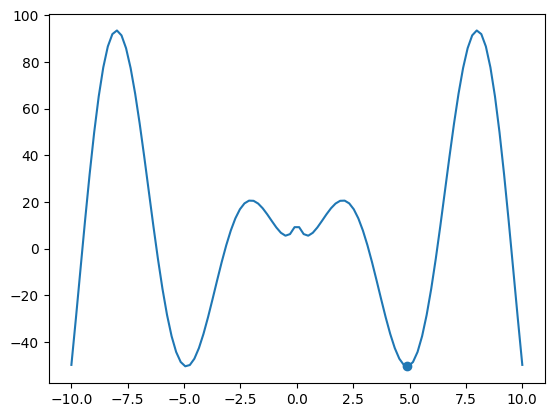

In [77]:
x = 5.0
gr = jax.grad(step)
g = gr(x)
for i in range(1000):
    x -= 0.01*g
    g = gr(x)
    if np.abs(g) < 0.01:
        break
xp = np.linspace(-10, 10, 100)
yp = step(xp)
plt.plot(xp,yp)
plt.scatter(x, step(x))
plt.show()

In [588]:
controller.step(params, 1, jnp.array([1]))

Array(7.98943, dtype=float32)

In [603]:
g = gradf(params, e, eh)
params = controller.update_params(params, 0.1, g)
e -= 0.5
eh = jnp.append(eh, e)
g, eh

([[Array([[-0., -0.],
          [-0., -0.],
          [-0., -0.]], dtype=float32),
   Array([[-0., -0.]], dtype=float32)],
  [Array([[0., 0.],
          [0., 0.]], dtype=float32),
   Array([[7.577401, 5.595716]], dtype=float32)],
  [Array([[1.7093694],
          [5.2147217]], dtype=float32),
   Array([[1.]], dtype=float32)]],
 Array([10. ,  9.5,  9. ,  8.5,  8. ,  7.5,  7. ,  6.5,  6. ,  5.5,  5. ,
         4.5,  4. ,  3.5,  3. ,  2.5], dtype=float32))

In [7]:
def mse(y, y_hat):
    return jnp.mean((y - y_hat)**2)

y = jnp.array([1,1,2,0])
y_hat = jnp.array([1,1,2,2])
mse(y, y_hat)

Array(1., dtype=float32)

In [22]:
def f(p):
    return p[0]*p[1] + p[1]

gradfunc = jax.value_and_grad(f)

params = [5.0, 5.0]
for i in range(10):
    v, g = gradfunc(params)
    g = np.array(g)
    params -= 0.01 * g

In [134]:

class Controller:
    def step(self, params, e, hist):
        de = e - hist[-1]
        ie = jnp.sum(hist) + e

        hist = jnp.append(hist, e)

        kp, kd, ki = params
        return (kp*e + kd*de + ki*ie).item()
        
    def reset(self):
        return jnp.array([0])
    
    def reset_params(self):
        return jnp.array([0,0,0])

    def update_params(self, params, gradient):
        return params - 0.01*gradient

controller = Controller()

In [ ]:
params = controller.reset_params()

gradfunc = jax.value_and_grad(controller.step)
for i in range(2):
    hist = controller.reset()
    e = 1/i

    controller.step(,)
    gradient = gradfunc(params, e, hist )
    params = controller.update_params(params, gradient)





In [1]:
controller

TypeError: can't multiply sequence by non-int of type 'float'

4

In [138]:
g = jax.grad(controller.step)

gradient = g(params, e, hist)
params = controller.update_params(params, gradient)

In [ ]:
g()

In [40]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from controller import NeuralController
from plant import BathtubPlant

controller = NeuralController(3,1, [], ['linear'])
plant = BathtubPlant(5.)

In [13]:
def _step_once(params, state, error, err_hist, target, noise):
    # Update plant and controller
    U = controller.step(params, error, err_hist)
    new_state = plant.step(state, U, noise)

    # Calculate error
    new_error = target - new_state
    err_hist = jnp.append(err_hist, new_error)
    return new_state, new_error, err_hist

@jax.value_and_grad
def sim(params, state, target, noise_vector, steps):

    error = target - state
    err_hist = jnp.array([error])
    for t in range(steps):
        # Perform one step
        state, error, err_hist = _step_once(
            params, state, error, err_hist, target, noise_vector[t]
        )
        
    return jnp.sum(jnp.array([e**2 for e in err_hist]))

# Initialization
params = controller.init_params()

# For each epoch
state, target = plant.reset()
jit = jax.jit(sim, static_argnames=['steps'])
res = jit(params, state, target, np.random.rand(10), 10)
res

(Array(2.4952376, dtype=float32),
 [[Array([[-0.16617365],
          [-0.53197396],
          [-0.        ]], dtype=float32),
   Array([[-0.5718249]], dtype=float32)]])

In [51]:
class Test:
    def calc(self, x):
        return x**2
    def d_calc(self, x):
        return jax.grad(self.calc)(x)
Test().d_calc(2.)


Array(4., dtype=float32, weak_type=True)

In [208]:
log = []

class Test:
    const = 5.
    def f(self, x):
        return self.const * x
F = Test()

In [215]:
jax.jit(jax.grad(F.f))(4.)

Array(5., dtype=float32, weak_type=True)

In [109]:
def fun(x):
    for i in range(10000):
        x += 1
    return x
f = jax.jit(jax.grad(fun))

In [89]:
def a(b,c):
    return 0
a(*[1,1])

0

In [10]:
sim(params, state, target, np.random.rand(10))

(Array(11.37813, dtype=float32),
 [[Array([[-1.0107554],
          [-3.8551273],
          [-0.       ]], dtype=float32),
   Array([[-1.2620955]], dtype=float32)]])

In [25]:
@jax.jit
def f(x):
    return x**2
g = jax.grad(g)
g = jax.jit(f)
g(1.)

Array(1., dtype=float32, weak_type=True)

In [ ]:
class Cont2:
    def step():
        pass

In [59]:
def inner(arr):
    return jnp.sum(arr)

def outer(n0, n):
    arr = jnp.array([n0])
    for _ in range(int(n)):
        arr = jnp.append(arr, inner(arr))
    return jnp.sum(arr)

g = jax.grad(outer)
g = jax.jit(g, static_argnums=[1])
g(1., 3.)
# outer(1., 2.)

Array(8., dtype=float32, weak_type=True)

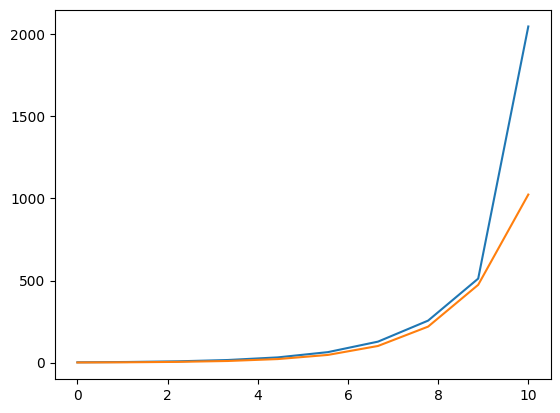

In [48]:
x = np.linspace(0, 10, 10)
y = np.array([outer(xi, 2.) for xi in x])
plt.plot(x,y)
plt.plot(x, 2**x)

In [38]:
a = np.array([1,2,3])
b = np.array([1,2,3])

np.dot(a,b)

14

In [193]:
layers = [3,2,1]
sender = layers[0]
params = []
for receiver in layers[1:]:
    weights = np.random.uniform(-1, 1, (sender, receiver))
    biases = np.random.uniform(-1, 1, (1, receiver))
    sender = receiver
    params.append([weights, biases])
params

[[array([[-0.77381592,  0.65954303],
         [-0.38216253,  0.4078683 ],
         [-0.97837197, -0.84118345]]),
  array([[ 0.1296642, -0.3155878]])],
 [array([[-0.13922578],
         [ 0.01645242]]),
  array([[0.30869945]])]]

In [205]:
@jax.grad
def forward(params, x):
    for (w, b) in params:
        x = jnp.dot(x, w) + b
        x = x.flatten()
    return x[0]

x = np.array([1,1,1], dtype=float)
grads = forward(params, x)
grads

[[Array([[-0.13922578,  0.01645242],
         [-0.13922578,  0.01645242],
         [-0.13922578,  0.01645242]], dtype=float32),
  Array([[-0.13922578,  0.01645242]], dtype=float32)],
 [Array([[-2.004686  ],
         [-0.08935991]], dtype=float32),
  Array([[1.]], dtype=float32)]]

In [206]:
jax.tree_map(
    lambda param, grad: param - 0.1*grad, params, grads
)

[[Array([[-0.75989336,  0.6578978 ],
         [-0.36823997,  0.40622306],
         [-0.9644494 , -0.8428287 ]], dtype=float32),
  Array([[ 0.14358677, -0.31723303]], dtype=float32)],
 [Array([[0.06124283],
         [0.02538841]], dtype=float32),
  Array([[0.20869946]], dtype=float32)]]

In [155]:
layers = [3,2,1]
sender = layers[0]
params = []
for receiver in layers[1:]:
    params.append({
        'weights': np.random.uniform(-1, 1, (sender, receiver)),
        'biases': np.random.uniform(-1, 1, (1, receiver))
    })
    sender = receiver
params

[{'weights': array([[-0.27760645,  0.04297027],
         [ 0.62270137,  0.81731209],
         [-0.34625636, -0.36697741]]),
  'biases': array([[-0.8466929 ,  0.79967142]])},
 {'weights': array([[0.79347396],
         [0.15120577]]),
  'biases': array([[0.6494983]])}]

In [190]:
x = np.array([1,1,1], dtype=float)
x = np.array([2,1,1], dtype=float)
# for w, b in zip(*(entry.values() for entry in params)):
@jax.grad
def forward(params, x):
    for layer in params:
        x = jnp.dot(x, layer['weights']) + layer['biases']
        x = x.flatten()
    return x[0]

grads = forward(params, x)
grads

TypeError: list indices must be integers or slices, not str

In [186]:
jax.tree_map(
    lambda param, grad: param - 0.1*grad, params, grads
)

[{'biases': Array([[-0.9260403 ,  0.78455085]], dtype=float32),
  'weights': Array([[-0.43630123,  0.01272912],
         [ 0.543354  ,  0.80219156],
         [-0.42560378, -0.382098  ]], dtype=float32)},
 {'biases': Array([[0.54949826]], dtype=float32),
  'weights': Array([[0.90602005],
         [0.0176111 ]], dtype=float32)}]

In [172]:
params

[{'weights': array([[-0.27760645,  0.04297027],
         [ 0.62270137,  0.81731209],
         [-0.34625636, -0.36697741]]),
  'biases': array([[-0.8466929 ,  0.79967142]])},
 {'weights': array([[0.79347396],
         [0.15120577]]),
  'biases': array([[0.6494983]])}]

In [123]:
jax.tree_map(lambda x : x.shape, params)

[{'1weights': (3, 2), 'biases': (1, 2)},
 {'1weights': (2, 1), 'biases': (1, 1)}]

In [5]:
class State:
    value = 0
    def __init__(self, value, **kwargs) -> None:
        self.value = value
        self.args = kwargs
F = Test(t=1)
F.args['t']

1

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from plant import RobotArmPlant
plant = RobotArmPlant(0, np.pi*0.1, 
                        dt=.1, 
                        length=2,
                        mass=10,
                        gravity=1)
state, error = plant.reset()

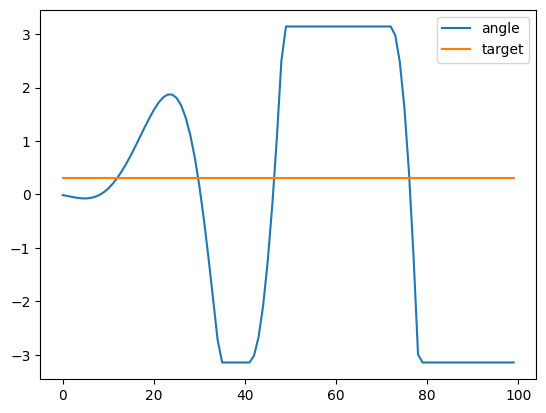

In [30]:
state, error = plant.reset()
state_log = []
control_log = []
error_log = [error, error]
params = np.array([
    0.1, 
    0.1,
    0.1,
])
for i in range(100):

    e = np.array(
        [error, np.sum(error_log), error-error_log[-2]])

    U = params@e.T

    state, error = plant.step(state, U, 0)
    state_log.append(state[0])
    control_log.append(U)
    error_log.append(error)
# plt.ylim(-np.pi, 0.1)
plt.plot(state_log, label="angle")
# plt.plot(control_log, label="torque")
plt.plot([plant.TARGET]*len(state_log), label="target")
plt.legend();

In [18]:
np.sign(10)

1

In [31]:
np.fmod(-12, np.pi)

-2.5752220392306207

In [ ]:
ø = max(-2*np.pi, ø)
ø = min(ø, 2*np.pi)

In [720]:
m = 30
l = 50
g = 9.81
F = 2
I = (m * np.power(l, 2)) / 3
dt = 0.01
ø, w, a = 0, 0, 0

In [782]:
def update(F):
    global ø, w, a
    T = (F - 0.5*l*m*g*np.cos(ø))
    a = T/I

    w = w + a*dt
    ø = ø + w*dt + 0.5*a*dt**2
    ø = np.fmod(ø, np.pi)
    return ø

update(0)
ø, w, a

(0.23678092933068262, 41.9445319100654, 0.2894030151744412)

In [787]:
ø, w, a, t = 0, 0, -1, 4
ø + w*t + 0.5*()*t**2

-8.0

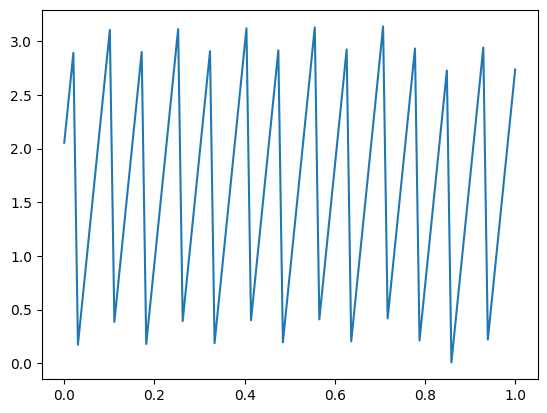

In [758]:
x = np.linspace(0, 1, 100)
y = np.array([update(0) for _ in x])
plt.plot(x, y)

In [136]:
def error(target, angle): 
    return np.mod(target - angle, 1)
error(1.1, - 1.1)

2.2


0.20000000000000018

In [134]:

np.mod(1.1 + 1.1, 1)

0.20000000000000018

In [ ]:
dW = F/I
dØ = W